# Programing exercise 5: ODE integrators

Due on Monday, 26.11.2018, 14.15h

### Total: 100 points

## The problem

We will again consider the collective Ising spin-model with a transverse field, as in programming exercise 4, which is governed by the Hamiltonian
$$
H=-\frac{J}{N}S_z^2 - \Omega S_x
$$
with the collective spin operators $S_\alpha = \sum_i \sigma_i^\alpha/2$, where $\sigma_i^\alpha$ is a Pauli operator acting on spin $i$. We studied this model in detail on the previous exercise sheet using exact diagonalization. Now we want to test how different numerical integrators perform on this problem and use exact diagonalziation as a benchmark.

In [1]:
# load standard libraries

import numpy as np   # standard numerics library
import numpy.linalg as LA
import scipy.linalg as sciLA

import matplotlib.pyplot as plt   # for making plots

import time as time

import scipy.sparse as sparse
import scipy.sparse.linalg as sLA
from scipy.sparse import coo_matrix

%matplotlib inline

### Exact diagonalization code

Here is an example implemetation of the exact diagonalization which you can use and compare to.

Definitions for building the Hamiltonian

In [2]:
def buildSx(N):
    Splusvec = np.sqrt((N-np.arange(0,N))*(np.arange(0,N)+1)) 
    Splus = sparse.diags(Splusvec,-1)
    return (Splus + Splus.T)/2

def buildSz(N):
    return sparse.diags(np.arange(N+1)-N/2)

def buildH(N,ome):
    Sx = buildSx(N)
    Sz = buildSz(N)
    return -Sz @ Sz/N - ome*Sx 

Here we calculate the time evolution using exact diagonalization. This will be used to benchmark the performance of the numerical integrators.

In [80]:
dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)
tvecED = tvec

ome = 0.6

N = 100
dim = N+1
ini = np.eye(1,dim,0)[0]

Sz = buildSz(N)
Sx = buildSx(N)
Sz2 = Sz @ Sz
Hmat =buildH(N,ome)
    
observables = 1j*np.zeros((2,len(tvec)))

# ED solution
t1=time.time()
evals, evecs = LA.eigh(Hmat.toarray())
# calculate projections on eigenstates
iniProj = evecs.conj().T @ ini
for i in range(len(tvec)):
    Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    observables[0,i] = Szval
    observables[1,i] = Sxval
t2=time.time()
print('time for ED was '+str(t2-t1))


if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesED = observables.real


time for ED was 0.04797077178955078


### Exercise 1 (15 points)

Now we want to use different integrators to see how they perform. A code for testing the Euler method has already been implemeted for you. Run it and describe your observations. Play with the step size in the 1st part.

Intergration with Euler:

Integrate with a given step size to see accuracy.

time for integration was 32.76303577423096


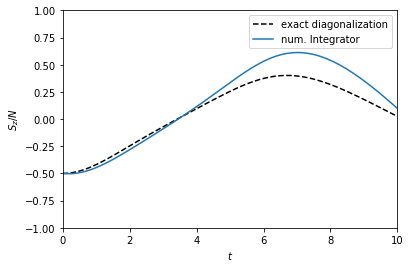

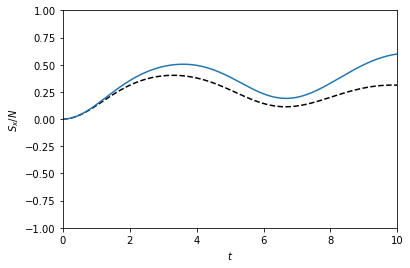

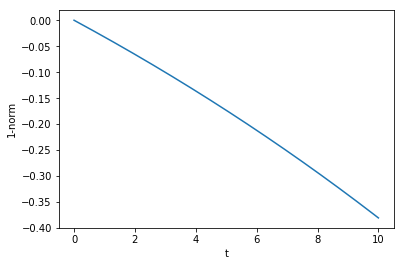

In [6]:
# Euler
def Euler_step(y,Hmat,dt,*more_args):
    return y - 1j*dt*Hmat @ y

stepper = Euler_step

dt = 0.0001
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

tvecIntegrator = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm
# Integration steps:
for i in range(1,len(tvec)):
    Psit = stepper(Psit, Hmat, dt)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for integration was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesIntegrator = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecIntegrator,1-observablesIntegrator[2])
# plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

In [126]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 11

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepsize in range(n_red_step):
    
    step_sizes[istepsize] = dt
    print(dt)
    # initialize
    Psit=ini

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,0] = Szval - observablesED[0,0]
    deviations[istepsize,1,0] = Sxval - observablesED[1,0]
    deviations[istepsize,2,0] = norm - 1
    
    # propagation
    for i in range(1,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit = stepper(Psit, Hmat, dt)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepsize,0,i] = Szval - observablesED[0,i]
        deviations[istepsize,1,i] = Sxval - observablesED[1,i]
        deviations[istepsize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625
0.0001953125
9.765625e-05
Some observables have non-zero imaginary parts!!


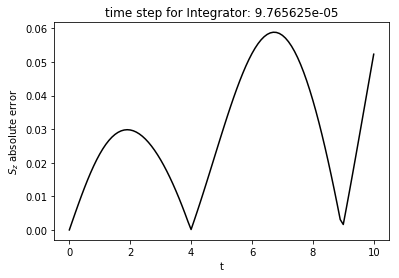

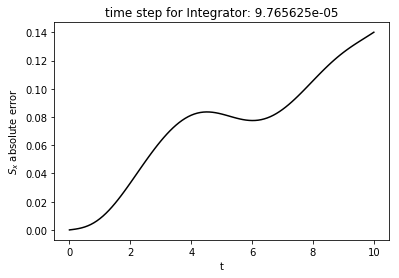

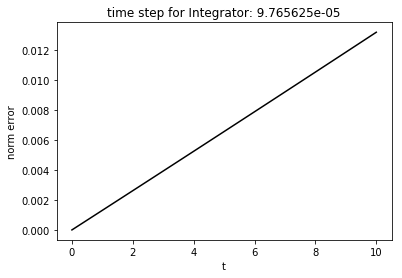

In [127]:
istepsize = -1
plt.plot(tvecED,deviations[istepsize,0],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,1],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,2],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

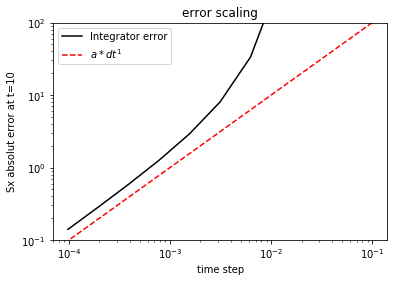

In [129]:
plt.loglog(step_sizes,deviations[:,1,-1],'k')
plt.loglog(step_sizes,10**3*step_sizes,'r--')
plt.title('error scaling')
plt.ylim([10**-1,10**2]) # Euler N=20
plt.legend(['Integrator error','$a*dt^1$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

Conslusions for Euler: 

We confirmed that the Euler integrator has global error that scales linearly with the time step size.

To reach an absolute error on the order of 0.1 in $S_x$ after t=10 time units, we need a time step of $10^{-4}$, which is really poor.

If the time step is too large ($>10^{-2}$) Euler quickly diverges.

The norm always increases exponentially. Thus we see that this integrator is unstable!

For $S_z$ the Euler solution oscillates around the exact (ED) solution. For $S_x$ the deviations increase almost monotonically.

We used N=20. For larger atom numbers we would need even smaller step size to get to t=10 before the norm explodes. (The largest eigenvlaue of the Hamiltonian is approximately $N/4$, which means that the ODE system gets more stiff.)


### Exercise 2 (40 points)

Do a corresponding anlysis for a second order Runge Kutta scheme (2nd order Taylor expansion of the evolution operator) and for the two-step method described in https://www5.in.tum.de/lehre/vorlesungen/wipro/ws16/folien/Askar_Explicit_Schroedinger.pdf
[equation (3.2)]. The two-step method matches the Taylor series to second order in dt, so we can use a RK2 step for initialization (to get $\psi_1$ from the initial wave function $\psi_0$).

For this case you can also go beyond $N=20$. Try at least $N=100$. With Euler, really tiny steps would be needed to prevent it from diverging in this case, but higher order integrators should do much better.

### RK2

time for integration was 2.038506507873535


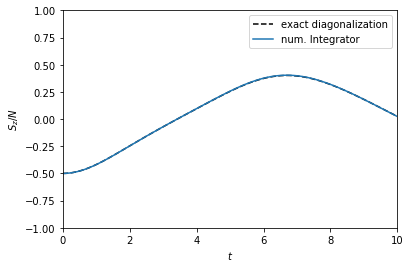

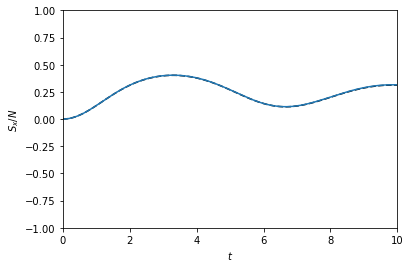

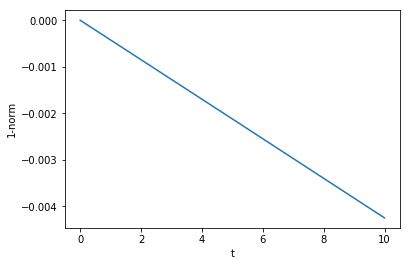

In [8]:
# second order Taylor expansion
def RK2_step(y,Hmat,dt,*more_args):
    return y - 1j*dt*Hmat @ y - dt**2/2*Hmat @ (Hmat @ y)

stepper = RK2_step

dt = 0.002
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

tvecIntegrator = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm
# Integration steps:
for i in range(1,len(tvec)):
    Psit = stepper(Psit, Hmat, dt)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for integration was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesIntegrator = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecIntegrator,1-observablesIntegrator[2])
# plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

In [10]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 11

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepsize in range(n_red_step):
    
    step_sizes[istepsize] = dt
    print(dt)
    # initialize
    Psit=ini

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,0] = Szval - observablesED[0,0]
    deviations[istepsize,1,0] = Sxval - observablesED[1,0]
    deviations[istepsize,2,0] = norm - 1
    
    # propagation
    for i in range(1,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit = stepper(Psit, Hmat, dt)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepsize,0,i] = Szval - observablesED[0,i]
        deviations[istepsize,1,i] = Sxval - observablesED[1,i]
        deviations[istepsize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625
0.0001953125
9.765625e-05
Some observables have non-zero imaginary parts!!


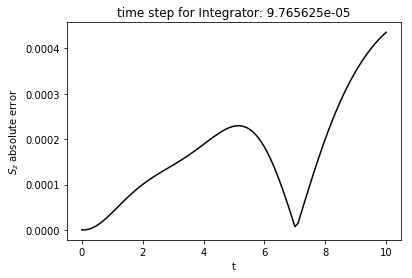

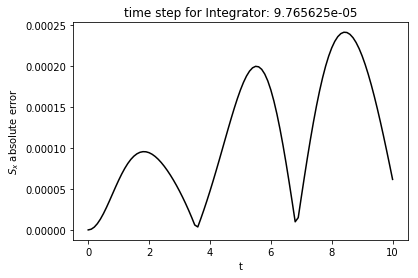

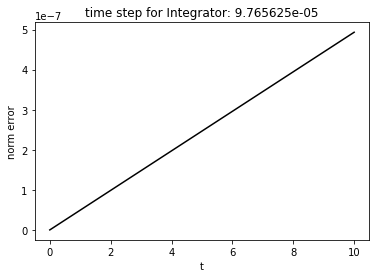

In [11]:
istepsize = 10
plt.plot(tvecED,deviations[istepsize,0],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,1],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,2],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

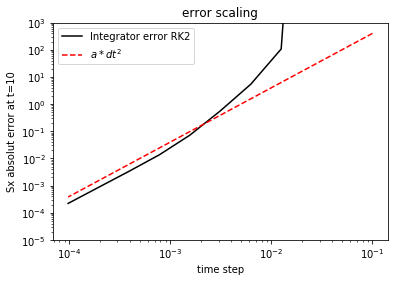

In [41]:
# here we average over the second half of the evolution and use Sz
plt.loglog(step_sizes,np.mean(deviations[:,0,int(len(tvecED)/2):],axis=1),'k')
plt.loglog(step_sizes,(2*10**2*step_sizes)**2,'r--')
plt.title('error scaling')
plt.ylim([10**-5,10**3]) # 
plt.legend(['Integrator error RK2','$a*dt^2$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

### Leap Frog

time for integration was 1.561760425567627


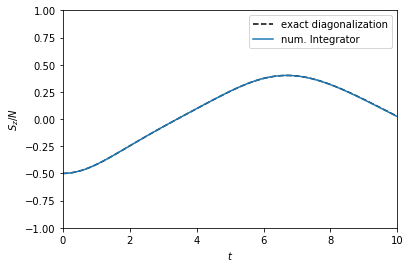

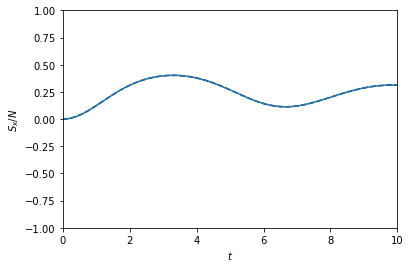

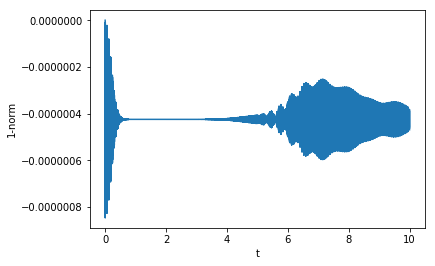

In [40]:
def TwoStep_step(y,ypre,Hmat,dt):
    return ypre - 2j*dt*Hmat @ y , y

dt = 0.002
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

tvecIntegrator = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm

# first step: RK2
PsiPre = Psit
# subdivide
dividestep = 1
for i in range(dividestep):
    Psit = RK2_step(Psit, Hmat, dt/dividestep)

i = 1
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,i] = Szval
observables[1,i] = Sxval
observables[2,i] = norm

# 2-step evolution
for i in range(2,len(tvec)):
    Psit, PsiPre = TwoStep_step(Psit,PsiPre, Hmat, dt)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for integration was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesIntegrator = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecIntegrator,1-observablesIntegrator[2])
# plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

In [47]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 10

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepsize in range(n_red_step):
    
    step_sizes[istepsize] = dt
    print(dt)
    
    # initialize
    Psit=ini

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,0] = Szval - observablesED[0,0]
    deviations[istepsize,1,0] = Sxval - observablesED[1,0]
    deviations[istepsize,2,0] = norm - 1
    
    # propagation
    
    # first step: RK2
    PsiPre = Psit
    Psit = RK2_step(Psit, Hmat, dt)
    for k in range(nsteps_per_dtout-1):
        Psit, PsiPre = TwoStep_step(Psit,PsiPre, Hmat, dt)
    

    i = 1
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,i] = Szval - observablesED[0,i]
    deviations[istepsize,1,i] = Sxval - observablesED[1,i]
    deviations[istepsize,2,i] = norm - 1
    
    for i in range(2,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit, PsiPre = TwoStep_step(Psit,PsiPre, Hmat, dt)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepsize,0,i] = Szval - observablesED[0,i]
        deviations[istepsize,1,i] = Sxval - observablesED[1,i]
        deviations[istepsize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625
0.0001953125
Some observables have non-zero imaginary parts!!


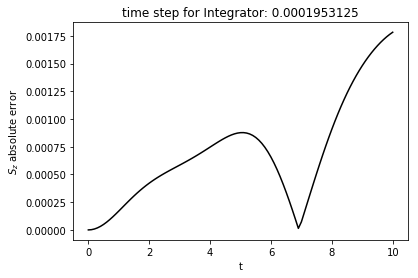

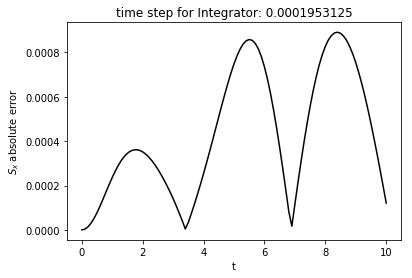

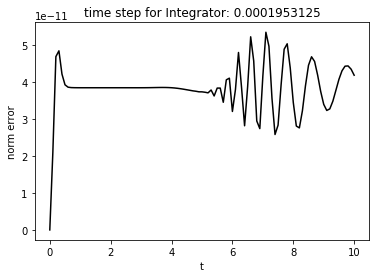

In [48]:
istepsize = 9
plt.plot(tvecED,deviations[istepsize,0],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,1],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,2],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

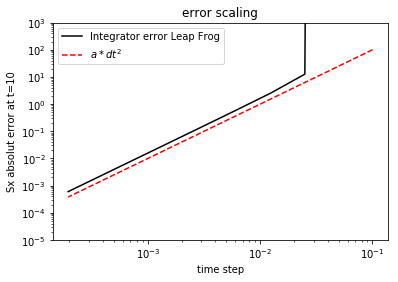

In [45]:
plt.loglog(step_sizes,np.mean(deviations[:,1,50:],axis=1),'k')
plt.loglog(step_sizes,(10**2*step_sizes)**2,'r--')
plt.title('error scaling')
plt.ylim([10**-5,10**3]) # 
plt.legend(['Integrator error Leap Frog','$a*dt^2$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

### Crank Nicolson

time for integration was 2.6870172023773193


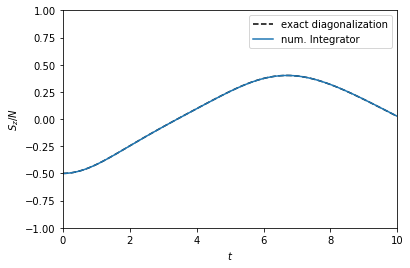

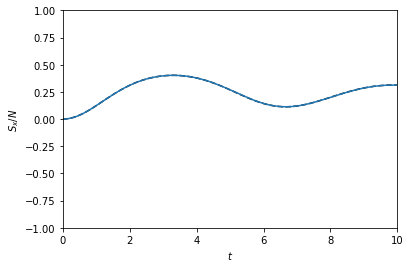

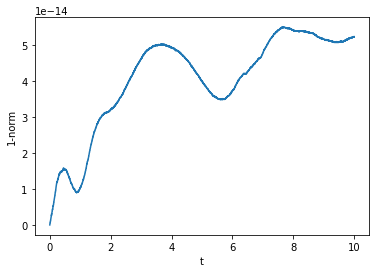

In [49]:
# Crank Nicolson
def CN_step(y,A,B):
    RHS = B @ y
    return sLA.spsolve(A,RHS)

stepper = CN_step

dt = 0.002
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

A = sparse.eye(N+1) + 1j*dt/2*Hmat
B = sparse.eye(N+1) - 1j*dt/2*Hmat

tvecIntegrator = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm
# Integration steps:
for i in range(1,len(tvec)):
    Psit = stepper(Psit,A,B)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for integration was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesIntegrator = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecIntegrator,1-observablesIntegrator[2])
# plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

In [50]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 10

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepsize in range(n_red_step):
    
    step_sizes[istepsize] = dt
    print(dt)
    # initialize
    Psit=ini
    
    A = sparse.eye(N+1) + 1j*dt/2*Hmat
    B = sparse.eye(N+1) - 1j*dt/2*Hmat

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,0] = Szval - observablesED[0,0]
    deviations[istepsize,1,0] = Sxval - observablesED[1,0]
    deviations[istepsize,2,0] = norm - 1
    
    # propagation
    for i in range(1,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit = stepper(Psit,A,B)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepsize,0,i] = Szval - observablesED[0,i]
        deviations[istepsize,1,i] = Sxval - observablesED[1,i]
        deviations[istepsize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625
0.0001953125


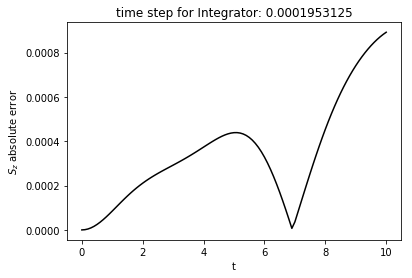

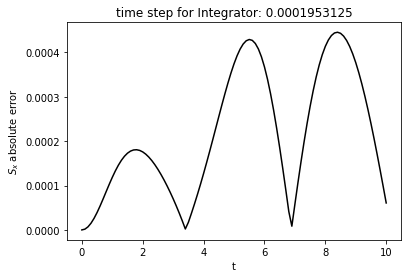

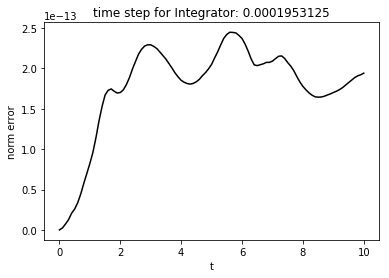

In [51]:
istepsize = 9
plt.plot(tvecED,deviations[istepsize,0],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,1],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,2],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

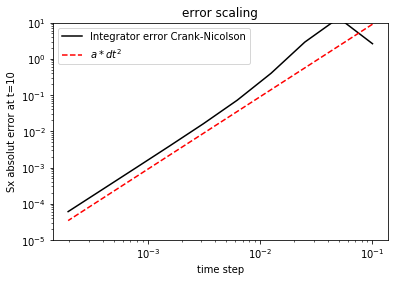

In [52]:
plt.loglog(step_sizes,deviations[:,1,-1],'k')
plt.loglog(step_sizes,(.3*10**2*step_sizes)**2,'r--')
plt.title('error scaling')
plt.ylim([10**-5,10**1]) # 
plt.legend(['Integrator error Crank-Nicolson','$a*dt^2$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

### RKn

time for integration was 5.709831476211548


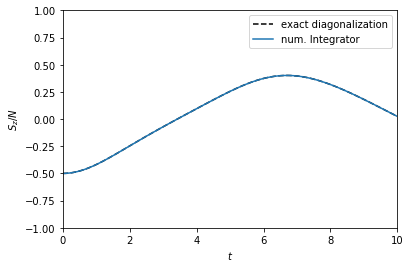

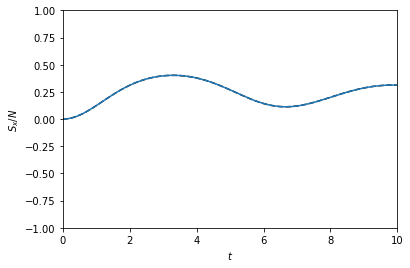

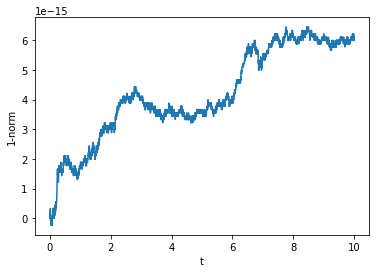

In [53]:
# nth order Taylor expansion
def RKn_step(y,Hmat,dt,n):
    yj = yout = y
    for i in range(1,n+1):
        yj = -1j*dt/i*Hmat @ yj
        yout = yout + yj
    return yout

stepper = RKn_step

n = 10
dt = 0.002
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

tvecIntegrator = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm
# Integration steps:
for i in range(1,len(tvec)):
    Psit = stepper(Psit, Hmat, dt, n)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for integration was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesIntegrator = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecIntegrator,1-observablesIntegrator[2])
# plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

In [54]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 10

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepsize in range(n_red_step):
    
    step_sizes[istepsize] = dt
    print(dt)
    # initialize
    Psit=ini

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,0] = Szval - observablesED[0,0]
    deviations[istepsize,1,0] = Sxval - observablesED[1,0]
    deviations[istepsize,2,0] = norm - 1
    
    # propagation
    for i in range(1,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit = stepper(Psit, Hmat, dt, n)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepsize,0,i] = Szval - observablesED[0,i]
        deviations[istepsize,1,i] = Sxval - observablesED[1,i]
        deviations[istepsize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625
0.0001953125


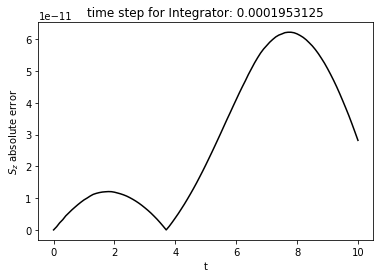

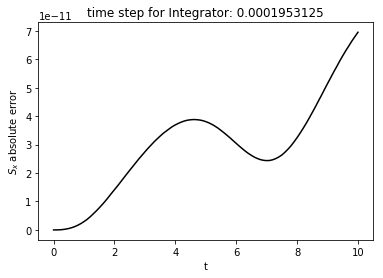

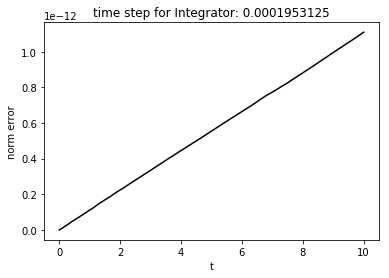

In [71]:
istepsize = 9
plt.plot(tvecED,deviations[istepsize,0],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,1],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,2],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

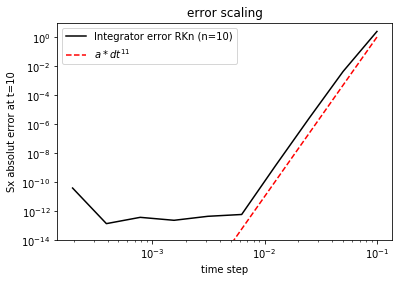

In [55]:
plt.loglog(step_sizes,np.mean(deviations[:,1,50:],axis=1),'k')
plt.loglog(step_sizes,(10**1*step_sizes)**11,'r--')
plt.title('error scaling')
plt.ylim([10**-14,10**1]) # 
plt.legend(['Integrator error RKn (n=10)','$a*dt^{11}$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

### Arnoldi

time for integration was 9.770776271820068


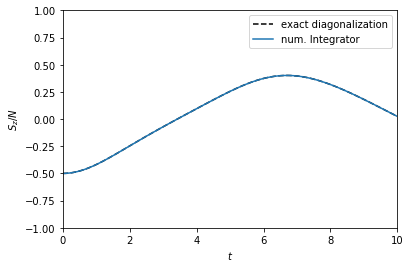

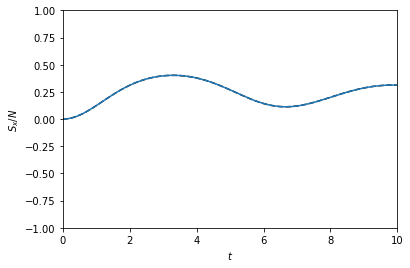

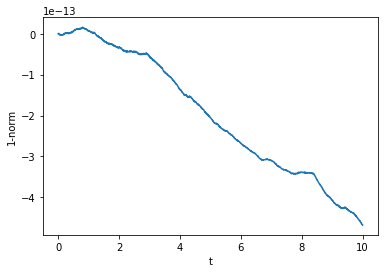

In [57]:
def generate_subspace(y,Hmat,n):
    # calculate Krylov space basis and h-matrix
    Qs = np.zeros( (N+1,n+1), dtype = complex)
    h = np.zeros( (n+1,n+1), dtype = complex)
    Qs[:,0] = y/LA.norm(y) # normalize just in case
    for i in range(1,n+1):
        v = Hmat @ Qs[:,i-1]
        if i > 1:
            hcol = Qs[:,(i-2):i].conj().T @ v
            h[(i-2):i,i-1] = hcol
            h[i-1,i-2] = hcol[0].conj()
            Qs[:,i] = v - np.sum(Qs[:,(i-2):i]*hcol.T,axis=-1)
        else:
            hcol = Qs[:,(i-1):i].conj().T @ v
            h[(i-1):i,i-1] = hcol
            Qs[:,i] = v - np.sum(Qs[:,(i-1):i]*hcol.T,axis=-1)
        norm = LA.norm(Qs[:,i])
        if norm < 10e-10: # If we already have an eigenstate, terminate. Rest of Qs and h can stay zero.
            return Qs, h
        Qs[:,i] /= norm
    # last row and column of h
    v = Hmat @ Qs[:,n]
    hcol = Qs[:,(n-1):(n+1)].conj().T @ v
    h[(n-1):(n+1),n] = hcol
    h[n,n-1] = hcol[0].conj()
    return Qs, h

def Arnoldi_step(y,Hmat,dt,n):
    Qs, h = generate_subspace(y,Hmat,n)
    return Qs @ (sciLA.expm(-1j*dt*h) @ (Qs.conj().T @ y))


stepper = Arnoldi_step

n = 10
dt = 0.002
tsteps = int(np.round(tend/dt)) # always integrate up to tend
tvec = np.linspace(0,dt*tsteps,tsteps+1)

tvecIntegrator = tvec;

observables = 1j*np.zeros((3,len(tvec))) # container for observables

t1=time.time() # measure time

Psit=ini # initialize wave function

# store initial values of observables
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,0] = Szval
observables[1,0] = Sxval
observables[2,0] = norm
# Integration steps:
for i in range(1,len(tvec)):
    Psit = stepper(Psit, Hmat, dt, n)
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
t2=time.time()
print('time for integration was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesIntegrator = observables.real


# plotting comparisons to ED and norm

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvecED,observablesED[1]/N,'k--')
plt.plot(tvecIntegrator,observablesIntegrator[1]/N)
plt.ylim([-1,1])
plt.xlim([0,tvecIntegrator[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_x/N$')
plt.show()

plt.plot(tvecIntegrator,1-observablesIntegrator[2])
# plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()

Loop over step size to see how error depends on it.

Output observables only at the points defined by the ED benchmark, i.e. subdivide time steps.

In [58]:
dtout = tvecED[1]-tvecED[0]

# in each iteration, divide the step size by some factor
red_factor = 2 # must be integer in this implementation
n_red_step = 9

deviations = 1j*np.zeros((n_red_step,3,len(tvecED))) # store only the deviations between numerical integration and ED.

dt = dtout
nsteps_per_dtout = 1

step_sizes = np.zeros((n_red_step)) # vector of time step sizes to try.

# decrease the time step in each iteration
for istepsize in range(n_red_step):
    
    step_sizes[istepsize] = dt
    print(dt)
    # initialize
    Psit=ini

    #initial values of observables
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    deviations[istepsize,0,0] = Szval - observablesED[0,0]
    deviations[istepsize,1,0] = Sxval - observablesED[1,0]
    deviations[istepsize,2,0] = norm - 1
    
    # propagation
    for i in range(1,len(tvecED)):
        # proparagte to next output time
        for k in range(nsteps_per_dtout):
            Psit = stepper(Psit, Hmat, dt, n)
        # record deviations    
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        deviations[istepsize,0,i] = Szval - observablesED[0,i]
        deviations[istepsize,1,i] = Sxval - observablesED[1,i]
        deviations[istepsize,2,i] = norm - 1
        
    # reduce time step
    dt = dt/red_factor
    nsteps_per_dtout = nsteps_per_dtout*red_factor


if np.max(deviations.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

deviations = np.abs(deviations)


0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625


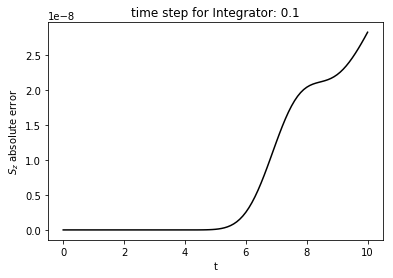

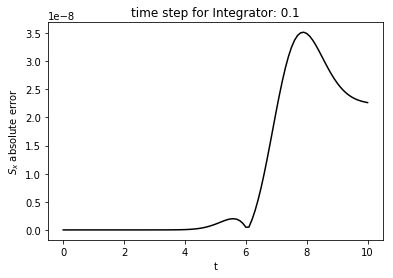

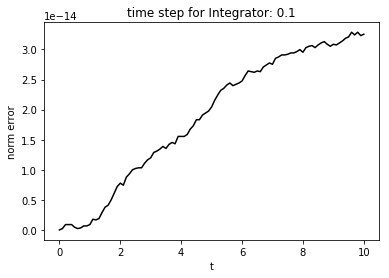

In [89]:
istepsize = 0
plt.plot(tvecED,deviations[istepsize,0],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_z$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,1],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('$S_x$ absolute error')
plt.show()

plt.plot(tvecED,deviations[istepsize,2],'k')
plt.title('time step for Integrator: '+ str(step_sizes[istepsize]))
plt.xlabel('t')
plt.ylabel('norm error')
plt.show()

Plot deviation as function of step size. Use a double log scale.

Here, use the diviation of Sx at the end time as an indicator for accuracy. One could also use other observables. If an observable oscillates in time around the exact value, it is better to use a time average over some time interval to quantify the error.

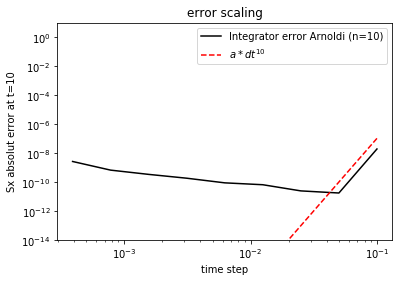

In [60]:
plt.loglog(step_sizes,np.mean(deviations[:,1,50:],axis=1),'k')
plt.loglog(step_sizes,(2*10**0*step_sizes)**10,'r--')
plt.title('error scaling')
plt.ylim([10**-14,10**1]) # 
plt.legend(['Integrator error Arnoldi (n=10)','$a*dt^{10}$'])
plt.xlabel('time step')
plt.ylabel('Sx absolut error at t=10')
plt.show()

### Exercise 3 (25 points)

Now we want to use a numerical intergrator from the scipy.integrate module. For this I reccomend using the "ode" class which gives the best control of parameters and greatest choice of methods. The documentation is here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode

Try different integrators and options. Use a fixed particle number of N=100. Describe your observations. For me, the options that worked best are given as an example below. If you find something faster/mor stable, let me know!

These integrators all use adaptive stepsize internally, so we don't have to analyze the step size dependence of the accuracy. They should in principle always give accurate results or otherwise give a warning message that the specified accuracy goal could not be reached.

In [77]:
# use a scipy out-of-the-box integrator

from scipy.integrate import ode

def f(t, y, Hmat):
    return -1j*Hmat @ y # RHS of the SE

# how efficient is @ for sparse matrices? Is there a more efficient mehtod?
# improvement by using the Jacobian?

time for adams was 0.3902013301849365


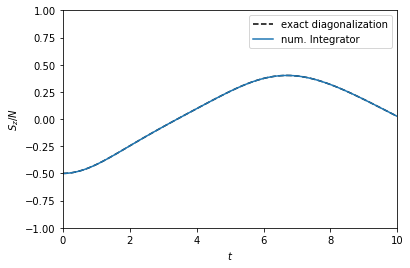

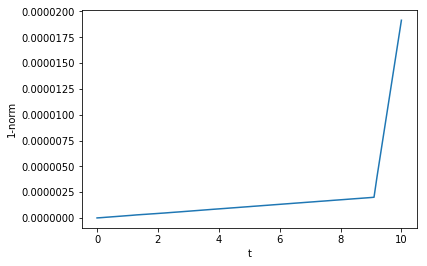

In [85]:
# initialize the integrator

y0, t0 = ini, 0

r = ode(f).set_integrator('zvode', method='adams', with_jacobian=False)
r.set_initial_value(y0, t0).set_f_params(Hmat)

t1 = tend
dt = .1
tsteps = int(t1/dt)
tvec = np.linspace(0,dt*tsteps,tsteps+1)
tvecScipy = tvec

observables= 1j*np.zeros((3,len(tvec)))

i=0

t1=time.time()

#initial values of observables
Psit = ini
i = 0
Szval = Psit.conj().T @ Sz @ Psit
Sxval = Psit.conj().T @ Sx @ Psit
norm = np.sqrt(Psit.conj().T @ Psit)
observables[0,i] = Szval
observables[1,i] = Sxval
observables[2,i] = norm

i+=1
while r.successful() and r.t < t1 and i<len(tvec):
    r.integrate(r.t+dt)
    Psit = r.y
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[0,i] = Szval
    observables[1,i] = Sxval
    observables[2,i] = norm
    i += 1

t2=time.time()
print('time for adams was '+str(t2-t1))

if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observablesScipy = observables.real

plt.plot(tvecED,observablesED[0]/N,'k--')
plt.plot(tvecScipy,observablesScipy[0]/N)
plt.ylim([-1,1])
plt.xlim([0,tvec[-1]])
plt.xlabel('$t$')
plt.ylabel('$S_z/N$')
plt.legend(['exact diagonalization','num. Integrator'])
plt.show()

plt.plot(tvec,1-observablesScipy[2])
#plt.ylim([0,2])
plt.xlabel('t')
plt.ylabel('1-norm')
plt.show()


### Exercise 4 (20 points)

Next, we want to check how their runtime for integrating our ODE scales with the number of spins N (or equivalently the Hilbert space dimension) and compare this to ED. Below is a code where you have to insert only your numerical integrator initialization and stepping.

For me, ED was still faster for up to N=1000. Try to find an integrator that beats by ED implementation!

Describe and interpret your observations.

[Optional] You can also try odeint (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) and/or solve_ivp (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp). These modules are less object oriented and have a restricted choice of integrators but are somewhat easier to use. 

All the documentation pages have a lot of useful information about the integrators and even links to the original publications in which they were introduced.

[Optional] Implement a Krylov subpace method. A good refernce on the details of this is https://www.sciencedirect.com/science/article/pii/S0010465598000836
The wikipadia page on the Arnoldi iteration even has a python sourrce code for constructing the Krylov vectors.

This method should work much better than the scipy integrators...

In [69]:
# Compare ED to scipy.integrate.ode

dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)

ome = 0.6

# running it to N=2000 takes a few minutes and starts to use significant memeory (for testing, reduce this!)
Nvals = np.arange(200,2001,100) 

observables = 1j*np.zeros((4,len(tvec),len(Nvals))) # for storing the results for Sz and Sx for both methods
runtimes = np.zeros((3,len(Nvals))) # store time for H buildup, ED, and numerical integration

for iN in range(len(Nvals)):
    
    N = Nvals[iN]
    print(N)
    dim = N+1
    ini = np.eye(1,dim,0)[0]

    Sz = buildSz(N)
    Sx = buildSx(N)
    
    t1=time.time()
    Hmat =buildH(N,ome)
    t2=time.time()
    runtimes[0,iN] = t2-t1 # time for H matrix buildup, should be negligible

    # ED solution
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    # calculate time evolution
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i,iN] = Szval
        observables[1,i,iN] = Sxval
    t2=time.time()
    runtimes[1,iN] = t2-t1 # time for ED

    # integrator solution
    t1=time.time()
    t0 = 0
    
    #initial values of observables
    Psit = ini
    i = 0
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[2,i,iN] = Szval
    observables[3,i,iN] = Sxval
    
    # scipy integrator
    # set up the integrator
    #r = ode(f).set_integrator('zvode', method='bdf',  with_jacobian=False)
    r = ode(f).set_integrator('zvode', method='adams', with_jacobian=False)
    r.set_initial_value(ini, t0).set_f_params(Hmat)

    i+=1
    while r.successful() and r.t < tend and i<len(tvec):
        r.integrate(r.t+dt)
        Psit = r.y
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[2,i,iN] = Szval
        observables[3,i,iN] = Sxval
        i += 1

    t2=time.time()
    runtimes[2,iN] = t2-t1 # time for integration
    
    
if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observables = observables.real

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


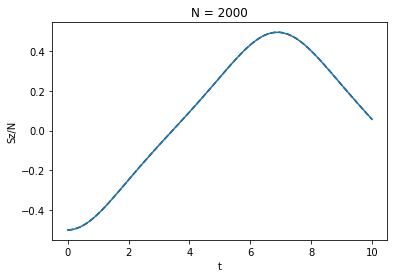

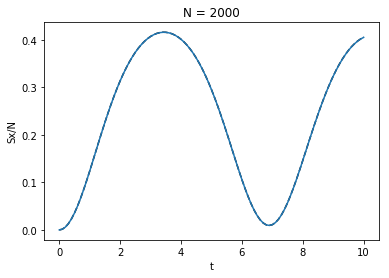

In [105]:
# plotting observables to check that integration was converged and accurate
iN=-1
plt.plot(tvec,observables[0,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[2,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sz/N')
plt.show()

plt.plot(tvec,observables[1,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[3,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sx/N')
plt.show()

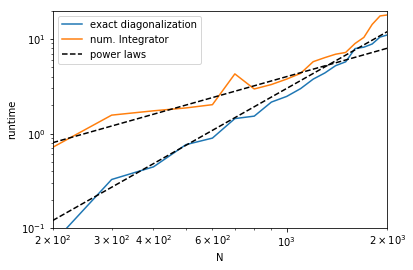

In [70]:
# plotting N-dependence of runtimes
plt.loglog(Nvals,runtimes[1])
plt.loglog(Nvals,runtimes[2])
plt.loglog(Nvals,0.004*Nvals,'k--')
plt.loglog(Nvals,3*10**-6*Nvals**2,'k--')
plt.ylim([10**-1,2*10**1])
plt.xlim([2*10**2,2*10**3])
plt.ylabel('runtime')
plt.xlabel('N')
plt.legend(['exact diagonalization','num. Integrator','power laws'])
plt.show()

In [71]:
# Compare ED to RKn

dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)

ome = 0.6

# running it to N=2000 takes a few minutes and starts to use significant memeory (for testing, reduce this!)
Nvals = np.arange(200,2001,100) 

observables = 1j*np.zeros((4,len(tvec),len(Nvals))) # for storing the results for Sz and Sx for both methods
runtimes = np.zeros((3,len(Nvals))) # store time for H buildup, ED, and numerical integration

for iN in range(len(Nvals)):
    
    N = Nvals[iN]
    print(N)
    dim = N+1
    ini = np.eye(1,dim,0)[0]

    Sz = buildSz(N)
    Sx = buildSx(N)
    
    t1=time.time()
    Hmat =buildH(N,ome)
    t2=time.time()
    runtimes[0,iN] = t2-t1 # time for H matrix buildup, should be negligible

    # ED solution
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    # calculate time evolution
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i,iN] = Szval
        observables[1,i,iN] = Sxval
    t2=time.time()
    runtimes[1,iN] = t2-t1 # time for ED

    # integrator solution
    t1=time.time()
    t0 = 0
    
    #initial values of observables
    Psit = ini
    i = 0
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[2,i,iN] = Szval
    observables[3,i,iN] = Sxval

    # RKn integrator
    n = 20    
    divideStep = 20
    for i in range(1,len(tvec)):
        for j in range(divideStep):
            Psit = RKn_step(Psit,Hmat,dt/divideStep,n)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        observables[2,i,iN] = Szval
        observables[3,i,iN] = Sxval

    t2=time.time()
    runtimes[2,iN] = t2-t1 # time for integration
    
    
if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observables = observables.real

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


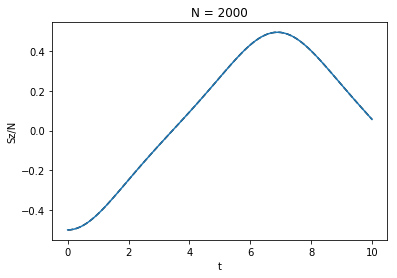

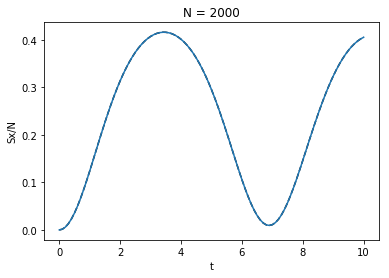

In [72]:
# plotting observables to check that integration was converged and accurate
iN=-1
plt.plot(tvec,observables[0,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[2,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sz/N')
plt.show()

plt.plot(tvec,observables[1,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[3,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sx/N')
plt.show()

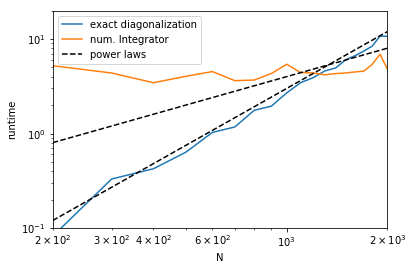

In [73]:
# plotting N-dependence of runtimes
plt.loglog(Nvals,runtimes[1])
plt.loglog(Nvals,runtimes[2])
plt.loglog(Nvals,0.004*Nvals,'k--')
plt.loglog(Nvals,3*10**-6*Nvals**2,'k--')
plt.ylim([10**-1,2*10**1])
plt.xlim([2*10**2,2*10**3])
plt.ylabel('runtime')
plt.xlabel('N')
plt.legend(['exact diagonalization','num. Integrator','power laws'])
plt.show()

In [74]:
# Compare ED to Arnoldi

dt = 0.1
tend = 10
tsteps = int(np.round(tend/dt))
tvec = np.linspace(0,dt*tsteps,tsteps+1)

ome = 0.6

# running it to N=2000 takes a few minutes and starts to use significant memeory (for testing, reduce this!)
Nvals = np.arange(200,2001,100) 

observables = 1j*np.zeros((4,len(tvec),len(Nvals))) # for storing the results for Sz and Sx for both methods
runtimes = np.zeros((3,len(Nvals))) # store time for H buildup, ED, and numerical integration

for iN in range(len(Nvals)):
    
    N = Nvals[iN]
    print(N)
    dim = N+1
    ini = np.eye(1,dim,0)[0]

    Sz = buildSz(N)
    Sx = buildSx(N)
    
    t1=time.time()
    Hmat =buildH(N,ome)
    t2=time.time()
    runtimes[0,iN] = t2-t1 # time for H matrix buildup, should be negligible

    # ED solution
    t1=time.time()
    evals, evecs = LA.eigh(Hmat.toarray())
    # calculate projections on eigenstates
    iniProj = evecs.conj().T @ ini
    # calculate time evolution
    for i in range(len(tvec)):
        Psit = evecs @ (np.exp(-1j*evals*tvec[i])*iniProj)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        observables[0,i,iN] = Szval
        observables[1,i,iN] = Sxval
    t2=time.time()
    runtimes[1,iN] = t2-t1 # time for ED

    # integrator solution
    t1=time.time()
    t0 = 0
    
    #initial values of observables
    Psit = ini
    i = 0
    Szval = Psit.conj().T @ Sz @ Psit
    Sxval = Psit.conj().T @ Sx @ Psit
    norm = np.sqrt(Psit.conj().T @ Psit)
    observables[2,i,iN] = Szval
    observables[3,i,iN] = Sxval

    # RKn integrator
    n = 20    
    divideStep = 3
    for i in range(1,len(tvec)):
        for j in range(divideStep):
            Psit = Arnoldi_step(Psit,Hmat,dt/divideStep,n)
        Szval = Psit.conj().T @ Sz @ Psit
        Sxval = Psit.conj().T @ Sx @ Psit
        norm = np.sqrt(Psit.conj().T @ Psit)
        observables[2,i,iN] = Szval
        observables[3,i,iN] = Sxval

    t2=time.time()
    runtimes[2,iN] = t2-t1 # time for integration
    
    
if np.max(observables.imag) > 0.001:
    print("Some observables have non-zero imaginary parts!!")

observables = observables.real

200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


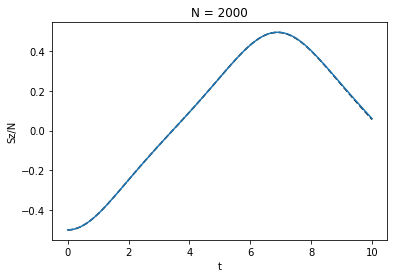

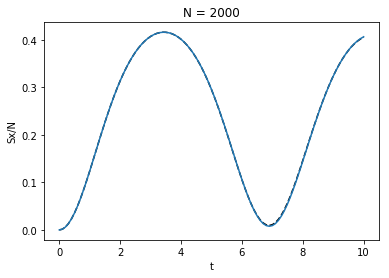

In [75]:
# plotting observables to check that integration was converged and accurate
iN=-1
plt.plot(tvec,observables[0,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[2,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sz/N')
plt.show()

plt.plot(tvec,observables[1,:,iN]/Nvals[iN],'k--')
plt.plot(tvec,observables[3,:,iN]/Nvals[iN])
plt.title('N = '+ str(Nvals[iN]))
# plt.ylim([-1,1])
# plt.xlim([0,tvecEuler[-1]])
plt.xlabel('t')
plt.ylabel('Sx/N')
plt.show()

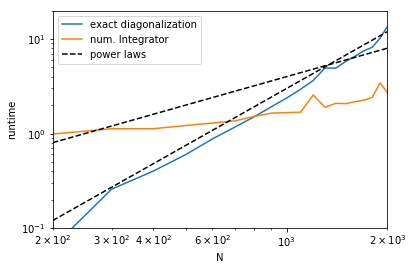

In [76]:
# plotting N-dependence of runtimes
plt.loglog(Nvals,runtimes[1])
plt.loglog(Nvals,runtimes[2])
plt.loglog(Nvals,0.004*Nvals,'k--')
plt.loglog(Nvals,3*10**-6*Nvals**2,'k--')
plt.ylim([10**-1,2*10**1])
plt.xlim([2*10**2,2*10**3])
plt.ylabel('runtime')
plt.xlabel('N')
plt.legend(['exact diagonalization','num. Integrator','power laws'])
plt.show()